In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as sp
import scipy.special 
import seaborn as sns
import scipy.ndimage
import scipy.signal as signal
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':20})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{mathrsfs}')
from matplotlib.gridspec import GridSpec

In [4]:
RC = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.edgecolor':' .15',
      'axes.linewidth':' 1.25',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 15,
     "xtick.major.size": 4, "ytick.major.size": 4}

plt.rcParams.update(RC)
sns.set_palette(sns.color_palette('dark'), n_colors=None, desat=None, color_codes=False)

In [5]:
#Define non-dimensional parameters for the (forced!) simulation 
Re = 4.150112e+03
Fr = 6.759636e-01
Ri = 1/((Fr/(2*np.pi)))**2
ch=50 #input column height

In [6]:
#Define dimensionless functions f and g from equations (2.14) and (2.15) in the manuscript
#These can be easily modified by the user
a = 1
b = 0.8
c = 0.9
d = 0.9 
def f(x):
    return 19/8 + 11/8*np.tanh(a*np.log(x)-b)

def g(x):
    return 2 + np.tanh(c*np.log(x)-d)

In [8]:
#Vertical slice of epsilon, dudz and drhotdz from forced simulation
eps = np.load('../data/DNS_data/Pr7_forced/eps.npy')
dudz = np.load('../data/DNS_data/Pr7_forced/dudz.npy')
drtdz = np.load('../data/DNS_data/Pr7_forced/drtdz.npy')

#Model predictions on this slice
#Single sample of outputs from PCNN
pcnn_eps = np.load('../data/PCNN_eps/pcnn_eps_sample_forced.npy')
#Means of ensemble of outputs from PCNN
pcnn_mean_eps = np.load('../data/PCNN_eps/pcnn_eps_means_forced.npy')
isotropic_eps = 15/4*dudz
empirical_eps = f(sp.signal.convolve2d(dudz, np.ones((1,50))/50, mode='same')*Re/Ri)*dudz

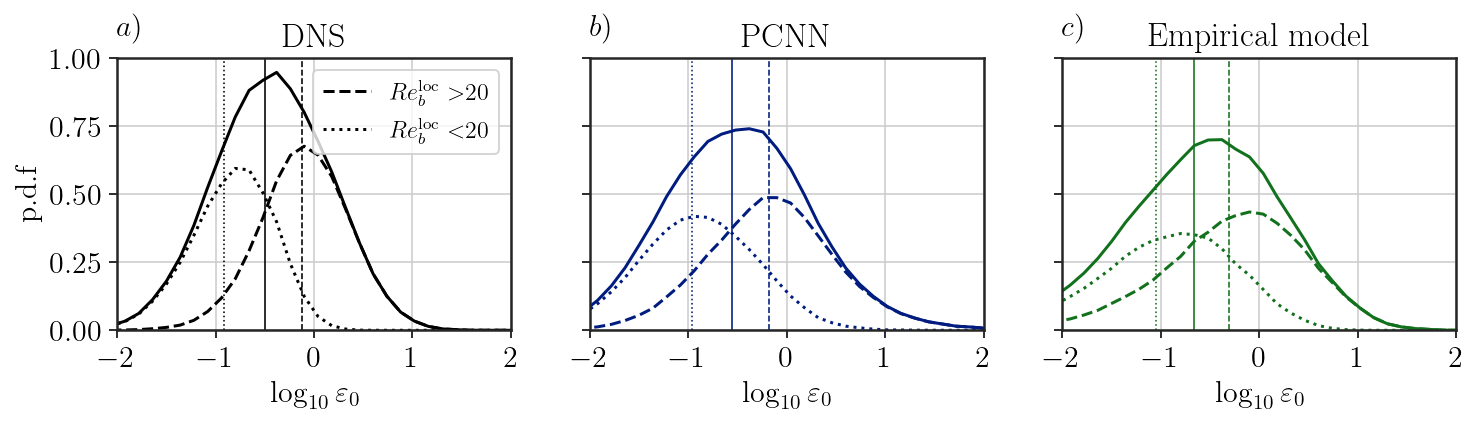

In [9]:
green = sns.color_palette('dark')[2]
blue = sns.color_palette('dark')[0]
orange = sns.color_palette('dark')[1]
fig=plt.figure(figsize=(12,2.5))
gs=GridSpec(1,3)
ax1 = fig.add_subplot(gs[0,0], rasterized=True)
ax2 = fig.add_subplot(gs[0,1], rasterized=True)
ax3 = fig.add_subplot(gs[0,2], rasterized=True)
axs = [ax1,ax2, ax3]
count=0
#Nominal cut-off Re_b (can be easily changed by the user)
reb_c = 20
for J in [0]:
    ax = axs[count]
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':15})
    #PCNN
    #Overall p.d.f.
    hist = np.histogram(np.log10(eps.flatten()), bins=50, range=(-5,2), density=False)
    #p.d.f. conditional on Re_b>Re_b^c
    hist_ = np.histogram(np.log10(eps[sp.ndimage.gaussian_filter(eps, sigma=(0, 15))*Re/Ri>reb_c]), range=(-5,2), bins=50, density=False)
    #p.d.f. conditional on Re_b<Re_b^c
    hist__ = np.histogram(np.log10(eps[sp.ndimage.gaussian_filter(eps, sigma=(0, 15))*Re/Ri<reb_c]), range=(-5,2), bins=50, density=False)
    
    #PCNN 
    hist2 = np.histogram(pcnn_eps.flatten(), bins=50, range=(-5,2), density=False)
    hist2_ = np.histogram((pcnn_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,15))*Re/Ri>reb_c]), range=(-5,2), bins=50, density=False)
    hist2__ = np.histogram((pcnn_eps[sp.ndimage.gaussian_filter(eps, sigma=(0, 15))*Re/Ri<reb_c]), range=(-5,2), bins=50, density=False)
    
    #Empirical model
    hist3 = np.histogram(np.log10(empirical_eps.flatten()), bins=50, range=(-5,2), density=False)
    hist3_ = np.histogram(np.log10(empirical_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,15))*Re/Ri>reb_c]), range=(-5,2), bins=50, density=False)
    hist3__ = np.histogram(np.log10(empirical_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,15))*Re/Ri<reb_c]), range=(-5,2), bins=50, density=False)
        
    ax.plot(hist[1][1:], hist[0]/40000, linestyle='-', color='k')
    ax.plot(hist_[1][1:], hist_[0]/40000, label='$Re_b^{\\mathrm{loc}}>$'+'$'+str(reb_c)+'$', color='k', linestyle='--')
    ax.plot(hist__[1][1:], hist__[0]/40000, label='$Re_b^{\\mathrm{loc}}<$'+'$'+str(reb_c)+'$', color='k', linestyle='dotted')
    ax.axvline(np.mean(np.log10(eps)), color='k', linestyle='-', linewidth=.8)
    ax.axvline(np.mean(np.log10(eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri>reb_c])),
                color='k', linewidth=.8, linestyle='--')
    ax.axvline(np.mean(np.log10(eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri<reb_c])),
                color='k', linewidth=.8, linestyle='dotted')
    
    ax2.plot(hist2[1][1:], hist2[0]/40000, label='$\\mathrm{Model\ sample}$', color=blue)
    ax2.plot(hist2_[1][1:], hist2_[0]/40000, label='$\\mathrm{Model\ sample}$', color=blue, linestyle='--')
    ax2.plot(hist2__[1][1:], hist2__[0]/40000, label='$\\mathrm{Model\ sample}$', color=blue, linestyle='dotted')
    ax2.axvline(np.mean((pcnn_eps)), color=blue, linewidth=.8)
    ax2.axvline(np.mean(pcnn_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri>reb_c]),
                color=blue, linewidth=.8, linestyle='--')
    ax2.axvline(np.mean(pcnn_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri<reb_c]),
                color=blue, linewidth=.8, linestyle='dotted')
    
    ax3.plot(hist3_[1][1:], hist3[0]/40000,color=green, linestyle='-', label='$\\mathrm{Empirical\ surrogate}$')
    ax3.plot(hist3_[1][1:], hist3_[0]/40000,color=green, label='$\\mathrm{Empirical\ surrogate}$', linestyle='--')
    ax3.plot(hist3__[1][1:], hist3__[0]/40000,color=green, label='$\\mathrm{Empirical\ surrogate}$', linestyle='dotted')
    ax3.axvline(np.mean(np.log10(empirical_eps)), color=green, linewidth=.8)
    ax3.axvline(np.mean(np.log10(empirical_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri>reb_c])),
                color=green, linewidth=.8, linestyle='--')
    ax3.axvline(np.mean(np.log10(empirical_eps[sp.ndimage.gaussian_filter(eps, sigma=(0,10))*Re/Ri<reb_c])),
                color=green, linewidth=.8, linestyle='dotted')
    ax.set_ylim(0,1)
    ax.annotate( '$a)$',(-2,1.08), annotation_clip=False)
    ax.set_xlim(-2,2)
    ax2.set_ylim(0,1)
    ax2.annotate( '$b)$',(-2,1.08), annotation_clip=False)
    ax2.set_xlim(-2,2)
    ax3.set_ylim(0,1)
    ax3.annotate( '$c)$',(-2,1.08), annotation_clip=False)
    ax3.set_xlim(-2,2)
    ax.set_xlabel('$\\log_{10}\\varepsilon_0$')
    ax2.set_xlabel('$\\log_{10}\\varepsilon_0$')
    ax3.set_xlabel('$\\log_{10}\\varepsilon_0$')
    count+=1
ax1.set_ylabel('$\\mathrm{p.d.f}$')
ax1.set_title('$\\mathrm{DNS}$', size=17)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax2.set_title('$\\mathrm{PCNN}$',size=17)
ax3.set_title('$\\mathrm{Empirical\ model}$',size=17)
ax1.legend(loc='upper right', fontsize=12)
fig.show()